# BUILDING CLOSED LOOP TESTBED

This notebook describes how to create a closed loop system for an Antimony model.

In [1]:
if True:
    !pip install -q tellurium
    !pip install -q controlSBML

In [2]:
from controlSBML import ControlSBML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

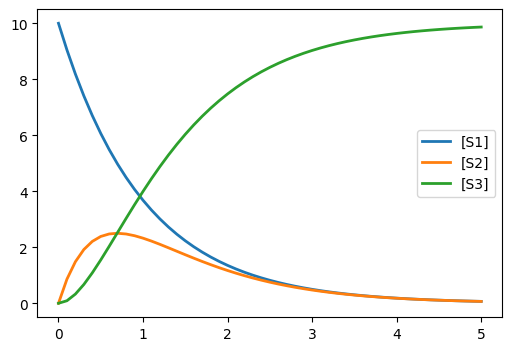

In [3]:
LINEAR_MODEL = """
model *main();
 S1 -> S2; k1*S1
 S2 -> S3; k2*S2
 k1 = 1
 k2 =2
 S1 = 10
 S2 = 0
 end
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot()

# Assignment Rules

Antimony has **assignment statements** that provide a way to do arithmetic on time varying values such as species concentrations. Assignment statements are indicated by ``:=``.

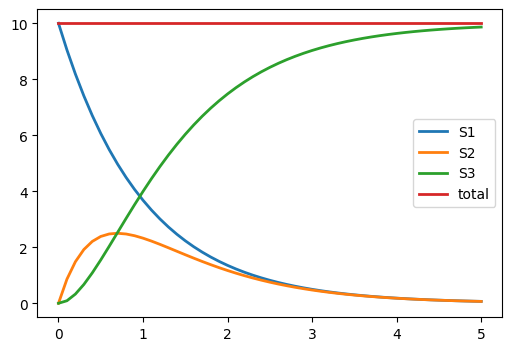

In [4]:
AUGMENTED_LINEAR_MODEL = """
 S1 -> S2; k1*S1
 S2 -> S3; k2*S2
 k1 = 1
 k2 = 2
 S1 = 10
 S2 = 0

 # Assignment
 total := S1 + S2 + S3
"""
rr = te.loada(AUGMENTED_LINEAR_MODEL)
rr.simulate(selections=['time', 'S1', 'S2', 'S3', 'total'])
rr.plot()

# Implementing controllers

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/simple_closed_loop.png"
     alt="Markdown Monster icon"
     width="400" height="120"
     style="float: left; margin-right: 10px;" />

Once we know the system control input and measured output, we can use assignment statements to create a feedback loop. This does require that the control input species be a fixed species (with a ``$``).

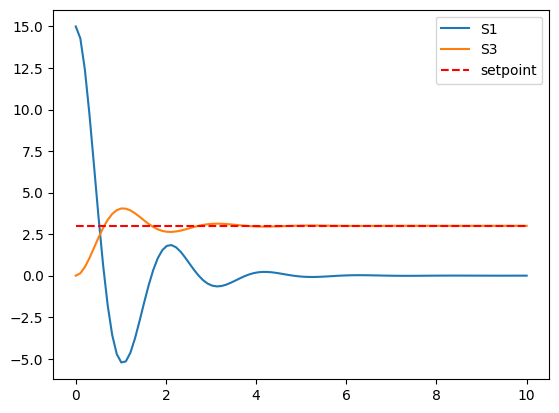

In [5]:
P_CONTROL_LINEAR_MODEL = """
 S1 -> S2; k1*S1
 S2 -> S3; k2*S2
 k1 = 1
 k2 =2
 $S1 = 10
 S2 = 0
 # Control design
 kP = 1
 kI = 0
 kD = 0
 setpoint = 3
 error := setpoint - S3
 S1 := kP*error
"""

rr = te.loada(P_CONTROL_LINEAR_MODEL)
rr['kP'] = 5
data = rr.simulate(0, 10, 100, selections=['time', 'S1', 'S3'])
times = data[:, 0]
for idx, name in enumerate(data.colnames[1:]):
    column = '[' + name + ']'
    plt.plot(times, data[:, idx+1])
plt.plot([0, max(times)], [rr['setpoint'], rr['setpoint']], color='red', linestyle='--')
plt.legend(['S1', 'S3', 'setpoint'])

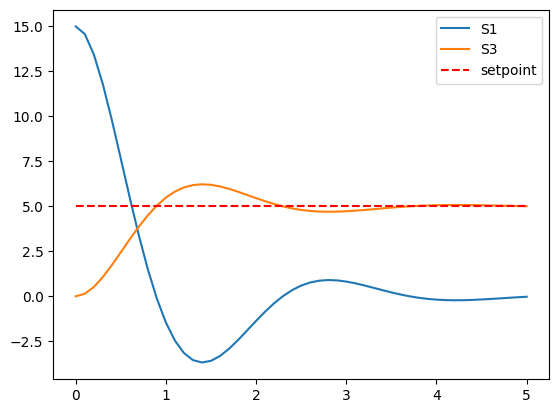

In [6]:
def runController(model, setpoint:float, kP:float=0, kI:float=0, kD:float=0,
                  input_name:str='S1', output_name:str='S3', is_plot:bool=True):
    # Run a model with a PID controller and the specified control input and measured output.
    # Assumes that 'setpoint' is the name of the setpoint
    rr = te.loada(model)
    rr['setpoint'] = setpoint
    rr['kP'] = kP
    rr['kI'] = kI
    rr['kD'] = kD
    selections = ['time', input_name, output_name]
    data = rr.simulate(selections=selections)
    times = data[:, 0]
    for idx, name in enumerate(data.colnames[1:]):
        column = '[' + name + ']'
        plt.plot(times, data[:, idx+1])
    plt.plot([0, max(times)], [rr['setpoint'], rr['setpoint']], color='red', linestyle='--')
    plt.legend([input_name, output_name, 'setpoint'])
    if not is_plot:
        plt.close()

# Tests
setpoint = 5
runController(P_CONTROL_LINEAR_MODEL, setpoint, kP=3, is_plot=True)

# PI Control

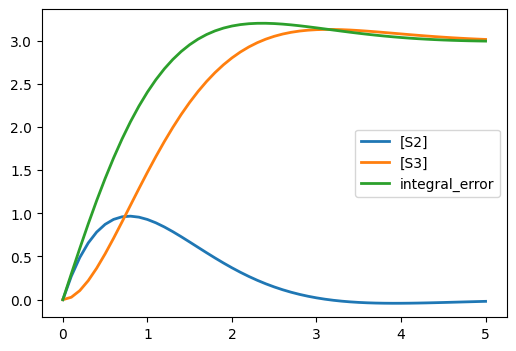

In [7]:
PI_CONTROL_LINEAR_MODEL = """
 S1 -> S2; k1*S1
 S2 -> S3; k2*S2
 k1 = 1
 k2 =2
 $S1 = 10
 S2 = 0
 # Control design
 kP = 1
 kI = 0
 kD = 0
 setpoint = 3
 integral_error = 0
 error := (setpoint - S3)
 integral_error' = error
 S1 := kP*error + kI*integral_error
"""
rr = te.loada(PI_CONTROL_LINEAR_MODEL)
rr.simulate()
rr.plot()

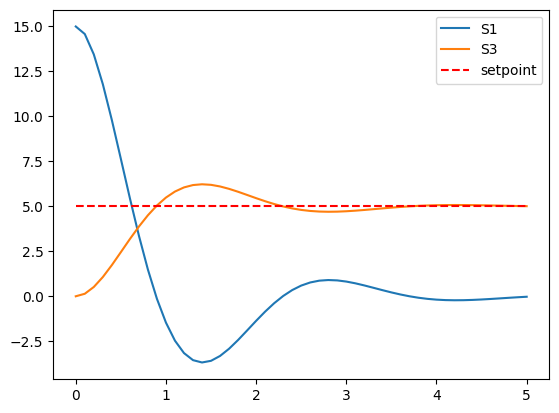

In [8]:
runController(PI_CONTROL_LINEAR_MODEL, setpoint=5, kP=3, is_plot=True)

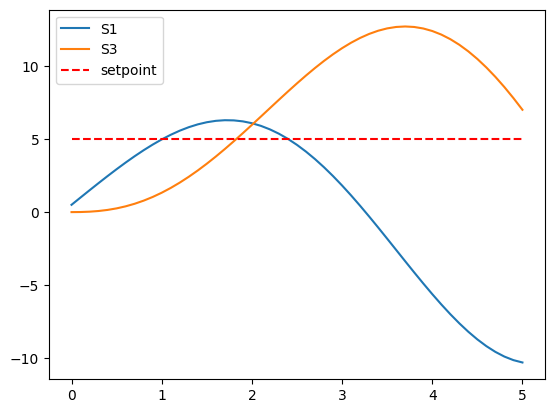

In [9]:
runController(PI_CONTROL_LINEAR_MODEL, setpoint=5, kP=0.1, kI=1, is_plot=True)

# PID Control

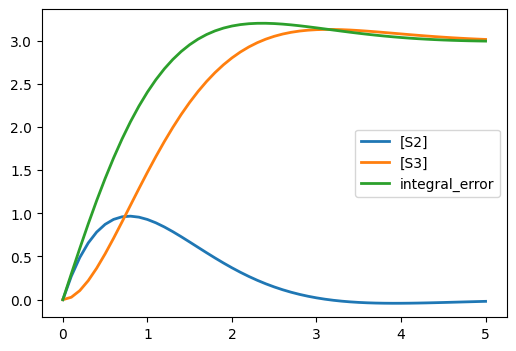

In [10]:
PID_CONTROL_LINEAR_MODEL = """
 S1 -> S2; k1*S1
 S2 -> S3; k2*S2
 k1 = 1
 k2 =2
 $S1 = 10
 S2 = 0
 # Control design
 kP = 1
 kI = 0
 kD = 0
 setpoint = 3
 integral_error = 0
 error := (setpoint - S3)
 integral_error' = error
 derivative_error := -rateOf(S3)
 S1 := kP*error + kI*integral_error + kD*derivative_error
"""
rr = te.loada(PID_CONTROL_LINEAR_MODEL)
rr.simulate()
rr.plot()

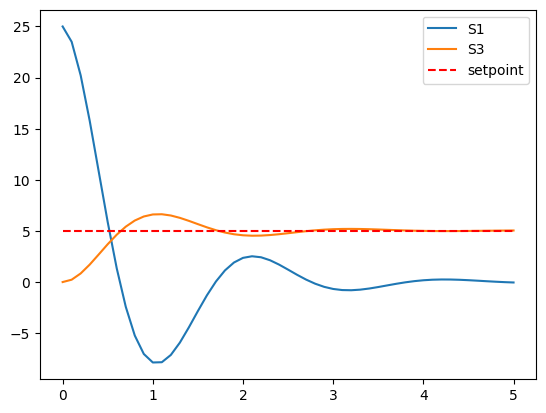

In [11]:
runController(PID_CONTROL_LINEAR_MODEL, setpoint=5, kP=5, kI=0.2, kD=0.1, is_plot=True)

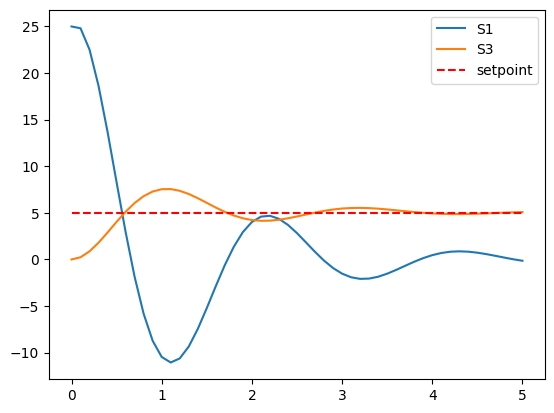

In [12]:
runController(PID_CONTROL_LINEAR_MODEL, setpoint=5, kP=5, kI=2, kD=0, is_plot=True)

# Control Design with ``controlSBML``


## Testbed construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [13]:
?ControlSBML.plotDesign

In [14]:
CTLSB = ControlSBML(LINEAR_MODEL, input_name="S1", output_name="S3")
#_ = CTLSB.plotDesign(setpoint=150, kP_spec=1)

100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


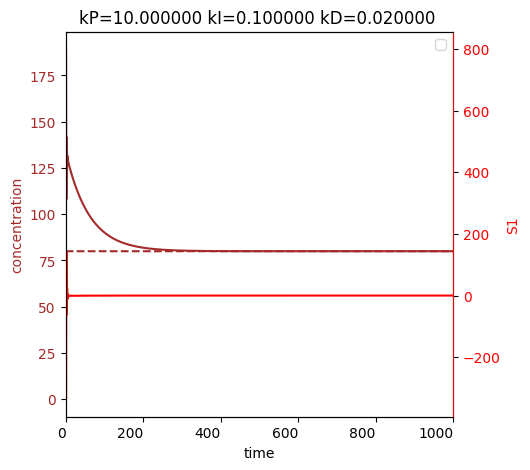

In [29]:
result = CTLSB.plotDesign(setpoint=80, kP_spec=10, kI_spec=0.1, kD_spec=0.02, times=np.linspace(0, 1000, 10000))

In [30]:
# The result has useful information
print(result.antimony_builder)
print(result.design_df)

// Created by libAntimony v2.15.0
model *main()

  // Compartments and Species:
  species S1, S2, S3;

  // Reactions:
  _J0: S1 -> S2; k1*S1;
  _J1: S2 -> S3; k2*S2;

  // Species initializations:
  S1 = 10;
  S2 = 0;
  S3 = ;

  // Variable initializations:
  k1 = 1;
  k2 = 2;

  // Other declarations:
  const k1, k2;

//vvvvvvvvvAdded by ControlSBMLvvvvvvvvvv
const S1

// Closed loop: S1 -> S3

// **CREATING CLOSED LOOP SYSTEM**
setpoint_S1_S3 = 80
S3 = 0.0

// Make sinusoid: NoiseSpec(sine_amp=0, sine_freq=0, random_mag=0 random_std=0, dc_gain=0, slope=0)
noise_S1_S3_ot := 0

// Make sinusoid: NoiseSpec(sine_amp=0, sine_freq=0, random_mag=0 random_std=0, dc_gain=0, slope=0)
disturbance_S1_S3_ot := 0

// Make filter: kF=None
kF_S1_S3 = 100
 -> filter_S1_S3_ot; -kF_S1_S3*filter_S1_S3_ot + kF_S1_S3*filter_S1_S3_in 
filter_S1_S3_ot = 0

// Make the PID controller
controller_kP_S1_S3 = 10.0
controller_kI_S1_S3 = 0.1
controller_kD_S1_S3 = 0.02
controller_derivative_error_S1_S3 := -1*-kF_